<a href="https://colab.research.google.com/github/hadinursalim/Bioinformatics/blob/main/Pros_ECG_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install -q keras

In [ ]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

# **Dataset**

In [ ]:
#dataset
train_df=pd.read_csv('/content/drive/MyDrive/Dataset ECG - MIT - BIH/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/Dataset ECG - MIT - BIH/mitbih_test.csv',header=None)

In [ ]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)
train_df.shape

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


(87554, 188)

In [ ]:
test_df[187]=test_df[187].astype(int)
equilibre=test_df[187].value_counts()
print(equilibre)
test_df.shape

0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


(21892, 188)

# **Visualization**

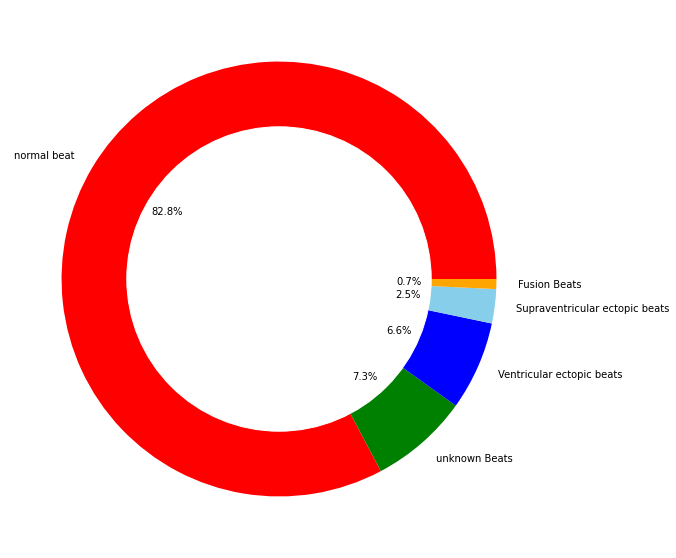

In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

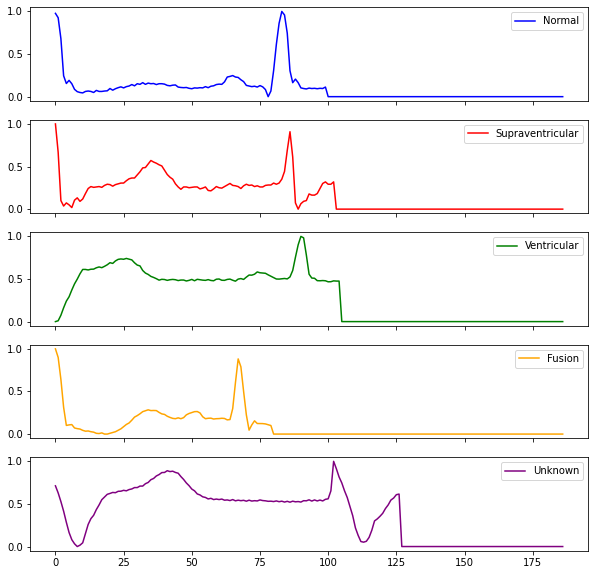

In [ ]:
# plot ECG data belonging to each class label
label = ["Normal","Supraventricular","Ventricular",
         "Fusion","Unknown"]
color = ['blue','red','green','orange','purple']
fig, ax = plt.subplots(5, 1, sharex=True, sharey=True,figsize=(10,10))
for i, row in enumerate(ax):
    row.plot((train_df[train_df[187] == i].iloc[0])[:-1], label=label[i], color=color[i])
    row.legend()

# **Resample**

In [ ]:
#resample
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [ ]:
equilibre=train_df[187].value_counts()
print(equilibre)

0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64


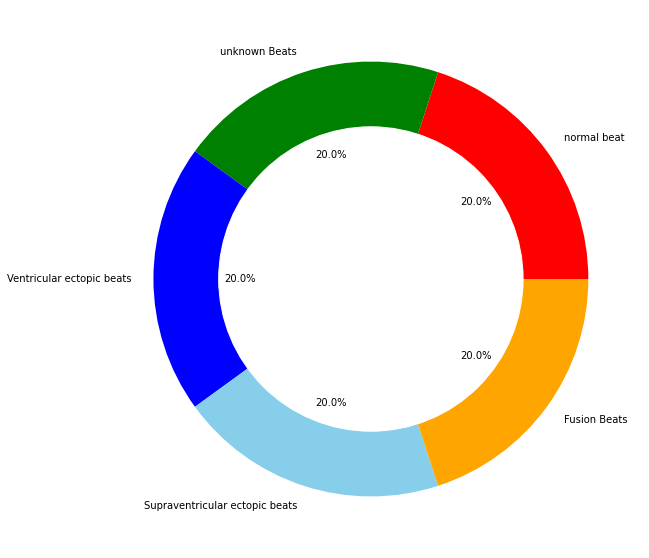

In [ ]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

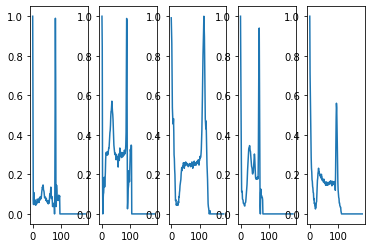

In [ ]:
plt.subplot(1, 5, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.plot(c.iloc[0,:186])
plt.subplot(1, 5, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.plot(c.iloc[1,:186])
plt.subplot(1, 5, 3)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.plot(c.iloc[2,:186])
plt.subplot(1, 5, 4)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.plot(c.iloc[3,:186])
plt.subplot(1, 5, 5)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.plot(c.iloc[4,:186])

plt.show()

In [ ]:
def plot_hist(class_number,size,min_):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


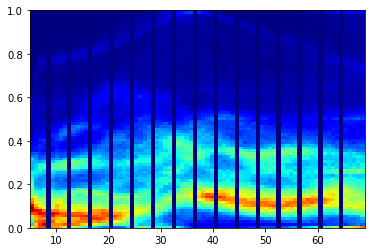

In [ ]:
plot_hist(0,70,5)

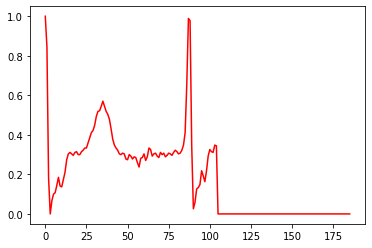

In [ ]:
plt.plot(c.iloc[1,:186],color='red')

900000
900000


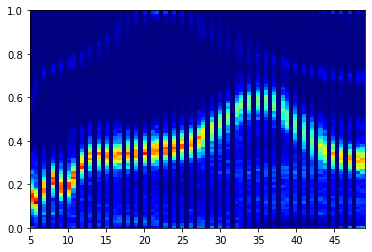

In [ ]:
plot_hist(1,50,5)

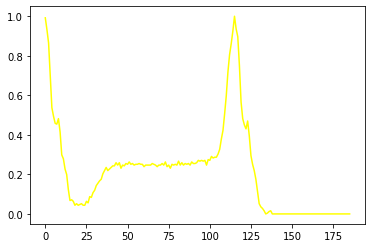

In [ ]:
plt.plot(c.iloc[2,:186],color='yellow')

600000
600000


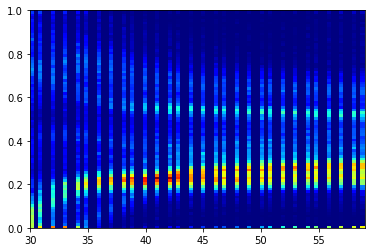

In [ ]:
plot_hist(2,60,30)

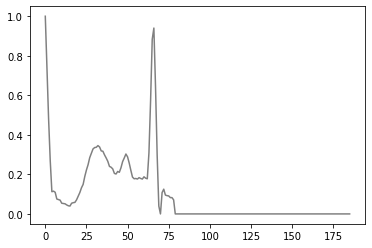

In [ ]:
plt.plot(c.iloc[3,:186],color='grey')

700000
700000


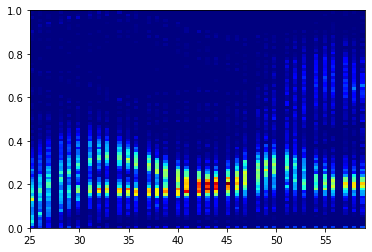

In [ ]:
plot_hist(3,60,25)

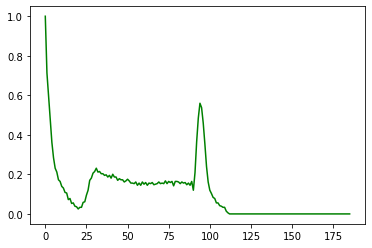

In [ ]:
plt.plot(c.iloc[4,:186],color='green')

640000
640000


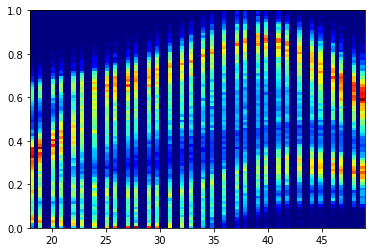

In [ ]:
plot_hist(4,50,18)

# **Gaussian Method**

In [ ]:
#Gaussian Method
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

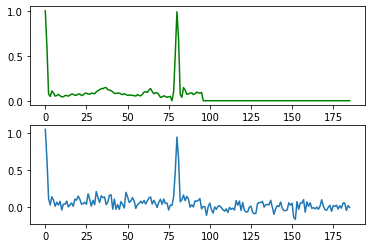

In [ ]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186],color='green')

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [ ]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [ ]:
X_train.shape

(100000, 186, 1)

In [ ]:
#train and test samples
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'testing samples')

100000 training samples
21892 testing samples


In [ ]:
train_df[187] = train_df[187].astype('int64')
target_col = train_df[187]
test_df[187] = test_df[187].astype('int64')
test_target_col = test_df[187]
labels = ['Normal beat','Supraventricular premature beat','Premature ventricular contraction','Fusion of ventricular and normal beat','Unclassifiable beat']

In [ ]:
X = train_df.drop(187,axis=1)
y = target_col
print(X.shape)
print(y.shape)

x_test = test_df.drop(187,axis=1)
y_test = test_df[187].astype('int64')
print(x_test.shape)
print(y_test.shape)

(100000, 187)
(100000,)
(21892, 187)
(21892,)


**Let's prepare a validation set which we will be useful for estimating model performance later.**

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(X,y.values,random_state=42,stratify=y.values,shuffle=True,train_size=0.75)
print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)

The shape of training data :  (75000, 187) (75000,)
The shape of validation data :  (25000, 187) (25000,)


**Distribution of samples on training dataset**

In [ ]:
pd.Series(np.bincount(y_train),index=labels)

Normal beat                              15000
Supraventricular premature beat          15000
Premature ventricular contraction        15000
Fusion of ventricular and normal beat    15000
Unclassifiable beat                      15000
dtype: int64

**Distribution of samples on validation dataset**

In [ ]:
pd.Series(np.bincount(y_val),index=labels)

Normal beat                              5000
Supraventricular premature beat          5000
Premature ventricular contraction        5000
Fusion of ventricular and normal beat    5000
Unclassifiable beat                      5000
dtype: int64

**Distribution of samples on testing dataset**

In [ ]:
pd.Series(np.bincount(y_test),index=labels)

Normal beat                              18118
Supraventricular premature beat            556
Premature ventricular contraction         1448
Fusion of ventricular and normal beat      162
Unclassifiable beat                       1608
dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [ ]:
import tensorflow as tf
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)
x_train = np.expand_dims(x_train, 2)
x_val = np.expand_dims(x_val, 2)
x_test = np.expand_dims(x_test, 2)
print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)
print("The shape of testing data : ",x_test.shape,y_test.shape)

The shape of training data :  (75000, 187, 1) (75000, 5)
The shape of validation data :  (25000, 187, 1) (25000, 5)
The shape of testing data :  (21892, 187, 1) (21892, 5)


In [ ]:
y_test[0]

array([1., 0., 0., 0., 0.], dtype=float32)

# **Data Modelling**

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation , Dropout, BatchNormalization, AveragePooling1D, ZeroPadding1D
from keras import backend as K
from keras import Sequential
from keras.initializers import glorot_uniform

# **Resnet model**

In [ ]:
n_obs, feature, depth = x_train.shape
batch_size = 256
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv1D(filters=F1, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(filters=F1, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X_shortcut = Conv1D(filters=F3, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=2, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet(input_shape=(feature,depth)):

    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)

    X = Conv1D(64, 7, strides=2, name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides= 2)(X)

    X = convolutional_block(X, f=3, filters=[128, 128, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [128, 128, 256], stage=2, block='b')
    X = identity_block(X, 3, [128, 128, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling1D(pool_size= 2, padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet')

    return model

In [ ]:
base_model = ResNet(input_shape=(feature,depth))

headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(5,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 193, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv1D)                 (None, 94, 64)       512         ['zero_padding1d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 94, 64)       256         ['conv1[0][0]']                  
                                                                                              

In [ ]:
model.compile(
          loss = 'categorical_crossentropy',
          optimizer = 'Adam',metrics = ['AUC']
                )

In [ ]:
import keras
h = model.fit(
      x_train,y_train,validation_data=(x_val,y_val),
                              epochs=25,batch_size=batch_size,
                        callbacks = [
                              keras.callbacks.ModelCheckpoint('./model_{val_auc:.3f}.h5',
                              save_best_only = True,save_weights_only=False,
                              monitor='val_auc')
                          ])

Epoch 1/25
293/293 [==============================] - 106s 261ms/step - loss: 0.4014 - auc: 0.9809 - val_loss: 1.7490 - val_auc: 0.6263
Epoch 2/25
293/293 [==============================] - 66s 226ms/step - loss: 0.1043 - auc: 0.9977 - val_loss: 0.1299 - val_auc: 0.9962
Epoch 3/25
293/293 [==============================] - 67s 230ms/step - loss: 0.0769 - auc: 0.9985 - val_loss: 0.0758 - val_auc: 0.9983
Epoch 4/25
293/293 [==============================] - 67s 228ms/step - loss: 0.0621 - auc: 0.9988 - val_loss: 0.0907 - val_auc: 0.9969
Epoch 5/25
293/293 [==============================] - 69s 235ms/step - loss: 0.0452 - auc: 0.9992 - val_loss: 0.0590 - val_auc: 0.9988
Epoch 6/25
293/293 [==============================] - 67s 228ms/step - loss: 0.0604 - auc: 0.9988 - val_loss: 0.0968 - val_auc: 0.9979
Epoch 7/25
293/293 [==============================] - 65s 222ms/step - loss: 0.0419 - auc: 0.9994 - val_loss: 0.1399 - val_auc: 0.9952
Epoch 8/25
293/293 [==============================] - 

In [ ]:
model.save("./model.h5")

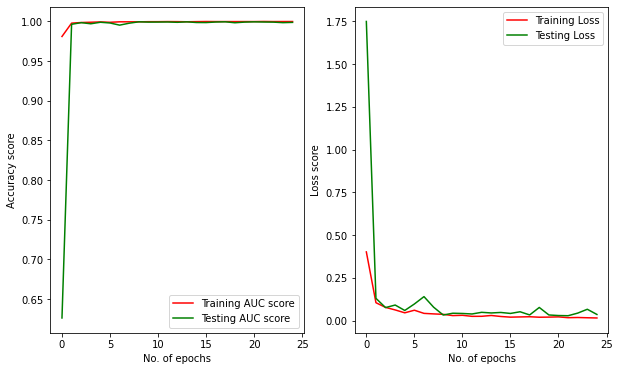

In [ ]:
## Model auc score and loss visualization
auc = h.history['auc']
val_auc=h.history['val_auc']
loss=h.history['loss']
val_loss=h.history['val_loss']

epochs=range(len(auc)) #No. of epochs

plt.figure(figsize=(10,6))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.plot(epochs,auc,'r',label='Training AUC score')
ax0.plot(epochs,val_auc,'g',label='Testing AUC score')
ax0.legend()
ax0.set_xlabel('No. of epochs')
ax0.set_ylabel('Accuracy score')


ax1.plot(epochs,loss,'r',label='Training Loss')
ax1.plot(epochs,val_loss,'g',label='Testing Loss')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('Loss score')
ax1.legend()
plt.show()

**Validation auc score**

In [ ]:
model.evaluate(x_val,y_val)

782/782 [==============================] - 15s 18ms/step - loss: 0.0356 - auc: 0.9987


[0.03562129661440849, 0.9986513257026672]

**Testing auc score**

In [ ]:
model.evaluate(x_test,y_test)

685/685 [==============================] - 11s 16ms/step - loss: 0.1249 - auc: 0.9941


[0.1248588114976883, 0.9941250085830688]

**Prediction on validation dataset**

In [ ]:
y_pre_val = model.predict(x_val)
y_pred_val = np.zeros(y_pre_val.shape[0])
for i in range(y_pred_val.shape[0]):
    y_pred_val[i] = np.argmax(y_pre_val[i])
y_pred_val = tf.keras.utils.to_categorical(y_pred_val)

**Prediction on Testing dataset**

In [ ]:
y_pre = model.predict(x_test)
y_pred = np.zeros(y_pre.shape[0])
for i in range(y_pred.shape[0]):
    y_pred[i] = np.argmax(y_pre[i])
y_pred = tf.keras.utils.to_categorical(y_pred)

# **Results**

**For validation dataset**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
print(classification_report(y_true=y_val,y_pred=y_pred_val))
f1_score_per_class_validation = f1_score(y_true=y_val,y_pred=y_pred_val,average=None) 
print("The f1-score per class: ",f1_score_per_class_validation)
print("The f1-score : ",f1_score(y_true=y_val,y_pred=y_pred_val,average='weighted'))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5000
           1       0.98      1.00      0.99      5000
           2       0.99      0.99      0.99      5000
           3       0.99      0.99      0.99      5000
           4       1.00      1.00      1.00      5000

   micro avg       0.99      0.99      0.99     25000
   macro avg       0.99      0.99      0.99     25000
weighted avg       0.99      0.99      0.99     25000
 samples avg       0.99      0.99      0.99     25000

The f1-score per class:  [0.98669623 0.9899732  0.98879328 0.9926133  0.99769839]
The f1-score :  0.9911548774350272


**For testing dataset**

In [ ]:
print(classification_report(y_true=y_test,y_pred=y_pred))
f1_score_per_class_test = f1_score(y_true=y_test,y_pred=y_pred,average=None) 
print("The f1-score per class: ",f1_score_per_class_test)
print("The f1-score : ",f1_score(y_true=y_test,y_pred=y_pred,average='weighted'))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.66      0.87      0.75       556
           2       0.94      0.95      0.95      1448
           3       0.61      0.88      0.72       162
           4       0.99      0.99      0.99      1608

   micro avg       0.97      0.97      0.97     21892
   macro avg       0.84      0.93      0.88     21892
weighted avg       0.98      0.97      0.98     21892
 samples avg       0.97      0.97      0.97     21892

The f1-score per class:  [0.98610107 0.74863813 0.94718793 0.71898734 0.98630989]
The f1-score :  0.9755350092313931


**For validation dataset**

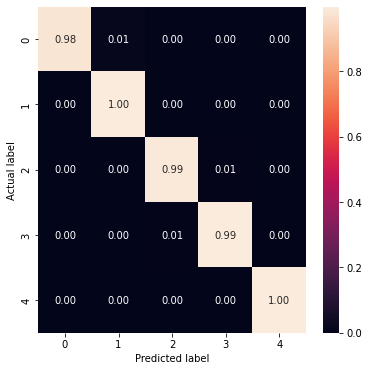

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(y_val,axis=1),y_pred=np.argmax(y_pred_val,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f',)
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**For testing dataset**

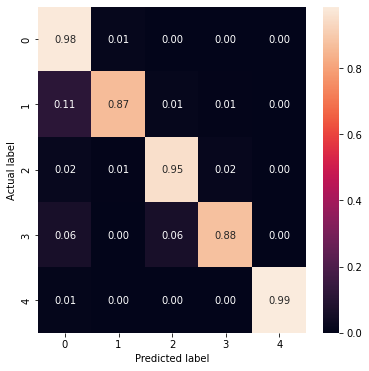

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(y_test,axis=1),y_pred=np.argmax(y_pred,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**For validation dataset**

In [ ]:
from sklearn.metrics import precision_score
print("The precision score : ",precision_score(y_true=y_val,y_pred=y_pred_val,average='weighted'))

The precision score :  0.9911965664382744


**For testing dataset**

In [ ]:
print("The precision score : ",precision_score(y_true=y_test,y_pred=y_pred,average='weighted'))

The precision score :  0.9780739946899345


**For validation dataset**

In [ ]:
from sklearn.metrics import accuracy_score
print("The accuracy score : ",accuracy_score(y_true=y_val,y_pred=y_pred_val))

The accuracy score :  0.99116


**For testing dataset**

In [ ]:
print("The accuracy score : ",accuracy_score(y_true=y_test,y_pred=y_pred))

The accuracy score :  0.9741458066873744


**For calculating average accuracy of our model on test set**

In [ ]:
num_models = 5
accuracy_scores = []
for num in range(num_models):
    print("Training model : ",num+1)
    h = model.fit(
          x_train,y_train,validation_data=(x_val,y_val),
                                  epochs=25,batch_size=batch_size,
                            callbacks = [
                                  keras.callbacks.ModelCheckpoint('./model_{val_auc:.3f}.h5',
                                  save_best_only = True,save_weights_only=False,
                                  monitor='val_auc')
                              ])
    y_pre = model.predict(x_test)
    y_pred = np.zeros(y_pre.shape[0])
    for i in range(y_pred.shape[0]):
        y_pred[i] = np.argmax(y_pre[i])
    y_pred = tf.keras.utils.to_categorical(y_pred)
    b = accuracy_score(y_true=y_test,y_pred=y_pred)
    print("The accuracy score of model "+str(num+1)+" : "+str(b))
    accuracy_scores.append(b)
print(accuracy_scores)
print("The average accuracy : ",np.mean(accuracy_scores))

Training model :  1
Epoch 1/25
293/293 [==============================] - 64s 219ms/step - loss: 0.0334 - auc: 0.9993 - val_loss: 0.1348 - val_auc: 0.9961
Epoch 2/25
293/293 [==============================] - 63s 216ms/step - loss: 0.0170 - auc: 0.9998 - val_loss: 0.0507 - val_auc: 0.9988
Epoch 3/25
293/293 [==============================] - 64s 218ms/step - loss: 0.0137 - auc: 0.9998 - val_loss: 0.0191 - val_auc: 0.9994
Epoch 4/25
293/293 [==============================] - 64s 220ms/step - loss: 0.0079 - auc: 0.9999 - val_loss: 0.0246 - val_auc: 0.9992
Epoch 5/25
293/293 [==============================] - 65s 220ms/step - loss: 0.0174 - auc: 0.9997 - val_loss: 0.0472 - val_auc: 0.9984
Epoch 6/25
293/293 [==============================] - 65s 221ms/step - loss: 0.0117 - auc: 0.9999 - val_loss: 0.0178 - val_auc: 0.9994
Epoch 7/25
293/293 [==============================] - 65s 221ms/step - loss: 0.0072 - auc: 0.9999 - val_loss: 0.0318 - val_auc: 0.9991
Epoch 8/25
293/293 [===============

**Validation Results**

In [ ]:
for i in range(len(labels)):
    print("The f1-score for class "+str(i)+" ("+str(labels[i])+") : ",f1_score_per_class_validation[i])

The f1-score for class 0 (Normal beat) :  0.9866962305986695
The f1-score for class 1 (Supraventricular premature beat) :  0.9899731956715974
The f1-score for class 2 (Premature ventricular contraction) :  0.9887932759655793
The f1-score for class 3 (Fusion of ventricular and normal beat) :  0.9926132960670793
The f1-score for class 4 (Unclassifiable beat) :  0.9976983888722104


**Test Results**

In [ ]:
for i in range(len(labels)):
    print("The f1-score for class "+str(i)+" ("+str(labels[i])+") : ",f1_score_per_class_test[i]) 

The f1-score for class 0 (Normal beat) :  0.9861010729971647
The f1-score for class 1 (Supraventricular premature beat) :  0.7486381322957198
The f1-score for class 2 (Premature ventricular contraction) :  0.9471879286694102
The f1-score for class 3 (Fusion of ventricular and normal beat) :  0.718987341772152
The f1-score for class 4 (Unclassifiable beat) :  0.9863098942128189
